In [227]:
from scipy.signal import firwin, lfilter, kaiserord, argrelmin
from scipy.interpolate import interp1d, CubicSpline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpt
import numpy as np
import math

# WALK ON: GAIT RECOGNITION IN-THE-WILD

## Introduction

The widespreading of wearable and portable IoT devices is greatly improving quality of life thanks to the development of 5G and data analysis techniques. Every device we use can collect data regarding our daily activities and use it to help improve their practice. However this can also lead to great security and privacy vulnerabilities when the data handling procedure is not carried out correctly.

With the data collected from devices we already carry every day (like our smartphones), it is possible to collect gait data that can be used to identify activities or individuals.

## Objective

This project has the objetive to use gait data collected from different subject's phones to create and train a deep learning model that will be capable of identifying users given their gait information.

In particular data from the accelerometer and gyroscope will be used to detect signal sequences relative to a step. These will then be classified to identify different users depending on their walking patterns.

This problem can be divided in two smaller tasks i.e. extraction of the signal relative to a step (this can be done with standard signal processing techniques), and then classification using a neural network.

The former will be addressed with the procedure proposed in [1], which was developed for mobile phone sensors, but can easily be extended to any other wearable device. Classification, on the other hand, will be addressed with a simple CNN.

[1] Gadaleta, Matteo, and Michele Rossi. "Idnet: Smartphone-based gait recognition with convolutional neural networks." Pattern Recognition 74 (2018): 25-37.

## Dataset acquisition

The datasets used for the exploration and development of this project are given by [2]. There are four datasets dedicated to the goals this project wants to achieve, so every one of them will be used in order to more accurately measure the results obtained by the developed model.

To test the model with all the different datasets, the reading of the desired dataset should be done first and then all the remaining processes should be runned afterwards. Everytime it is intended to switch the analyzed dataset, the process should be repeated.

[2] Zou Q, Wang Y, Zhao Y, Wang Q and Li Q, Deep learning-based gait recogntion using smartphones in the wild, IEEE Transactions on Information Forensics and Security, vol. 15, no. 1, pp. 3197-3212, 2020.

In [1]:
!mkdir datasets

### Utilities

Before the acquisition, reading and conversion of any dataset, a set of utility functions were set to better auxiliate in the reading and conversion process.

In [5]:
DATASET = 'datasets/dataset'
TRAIN = 'train'
TEST = 'test'
GYROSCOPE = 'gyr'
ACCELEROMETER = 'acc'
EXTENSION = '.txt'

def load_gait_information(x: str, y: str, z: str) -> np.array:
    '''
    Read all the x, y and z values of a dataset of a given device readings.

    Args:
        x (str): The path for the dataset of x readings.
        y (str): The path for the dataset of y readings.
        z (str): The path for the dataset of z readings.

    Returns:
        np.array: The 3 * Steps * 128 matrix of the read information.
    '''

    # Create the final matrix where the readings will be stored
    signals = []

    # Iterative process for every axis reading
    for path in [x, y, z]:

        # Create a temporary matrix for storing a single axis readings
        axis = []

        # Open the dataset file location
        file = open(path, 'r')

        # Read every row of the axis readings
        for row in file:

            # Conversion of the row values and addition to the axis matrix
            axis.append(np.array(row.strip().split(' '), dtype=np.float32))

        # Addition of the axis matrix to the readings matrix
        signals.append(axis)

        # Closing of the read file
        file.close()

    # Returning and conversion of the final readings matrix
    return np.array(signals)

def load_dev_gait_information(dataset: int, device: str, purpose: str) -> np.array:
    '''
    Read all the axis readings for a certain purpose of a certain device.

    Args:
        dataset (int): The number of the intended reading dataset.
        device (str): The nickname of the device wanted for reading.
        purpose (str): The nickname of the purpose wanted for reading.

    Returns:
        np.array: The 3 * Steps * 128 matrix of the read information.
    '''

    # Create the general reading path for the intended reading
    path = f'{DATASET}{dataset}/{purpose}_{device}_'

    # Create the array of reading paths
    paths = []

    # Interation between all the available reading axis
    for axis in ['x', 'y', 'z']:

        # Create the definitive path for a certain axis reading
        axis_path = path + axis + EXTENSION

        # Append the created path to the array of paths
        paths.append(axis_path)

    # Reading of the information and creation of the final matrix
    return load_gait_information(paths[0], paths[1], paths[2])

def load_all_gait_information(dataset: int, purpose: str) -> np.array:
    '''
    Read both of the devices datasets for a certain purpose.

    Args:
        dataset (int): The number of the intended reading dataset.
        purpose (str): The nickname of the purpose wanted for reading.

    Returns:
        np.array: The 6 * Steps * 128 matrix of the read information.
    '''

    # Reading for the accelerometer device
    acc = load_dev_gait_information(dataset, ACCELEROMETER, purpose)

    # Reading for the gyroscope device
    gyr = load_dev_gait_information(dataset, GYROSCOPE, purpose)

    # Returning of the concatenation of the readings of both devices
    return acc + gyr

def load_output_information(path: str) -> np.array:
    '''
    Read from a given path the output (y) information of every gait entry.

    Args:
        path (str): The destination of the dataset file for reading.

    Returns:
        np.array: The resulting vector of the read output information.
    '''

    # Open the dataset output file location
    file = open(path, 'r')

    # Read every row of the output readings
    readings = [row for row in file]

    # Convert and return the readings into float values
    return np.array(readings, dtype=np.float32)

def load_purpose_output_information(dataset: int, purpose: str) -> np.array:
    '''
    Read the outputs of the dataset for a certain purpose.

    Args:
        dataset (int): The number of the intended reading dataset.
        purpose (str): The nickname of the purpose wanted for reading.

    Returns:
        np.array: The resulting vector of the read output information.
    '''

    # Create the reading path for the intended reading
    path = f'{DATASET}{dataset}/y_{purpose}{EXTENSION}'

    # Reading and returning of the intended output readings
    return load_output_information(path)

def convert_to_model(matrix: np.array) -> np.array:
    '''
    Turns any given loaded dataset into an actual usable matrix for the model.

    Args:
        matrix (np.array): The loaded dataset matrix.

    Returns:
        np.array: The correctly converted Steps * 128 * 3 matrix of values.
    '''

    # Converts and returns the given loaded matrix
    return np.transpose(matrix, (1, 2, 0))

### Dataset #1 - 118 Subjects, Interpolation

In [ ]:
!wget 'https://drive.usercontent.google.com/download?id=1yPNWWeubU9SjRKqW7H4-q0BaNsw57jWc&export=download&authuser=0&confirm=t&uuid=f7baf6b2-4139-40d1-b1c1-9ff21f5d696d&at=AIrpjvMKaZOBaOKN_juwrHVVepG3%3A1737392898709' -O datasets/dataset1.zip

!unzip datasets/dataset1.zip -d datasets/dataset1

!find datasets/dataset1 -mindepth 2 -type f -exec mv -t datasets/dataset1 {} +

!rm -r datasets/dataset1/Dataset\ \#1

!rm datasets/dataset1.zip

Archive:  datasets/dataset1.zip
   creating: datasets/dataset1/Dataset #1/
   creating: datasets/dataset1/Dataset #1/test/
   creating: datasets/dataset1/Dataset #1/test/Inertial Signals/
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_acc_x.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_acc_y.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_acc_z.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_gyr_x.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_gyr_y.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_gyr_z.txt  
  inflating: datasets/dataset1/Dataset #1/test/y_test.txt  
   creating: datasets/dataset1/Dataset #1/train/
   creating: datasets/dataset1/Dataset #1/train/Inertial Signals/
  inflating: datasets/dataset1/Dataset #1/train/Inertial Signals/train_acc_x.txt  
  inflating: datasets/dataset1/Dataset #1/train/Inertial Signals/tra

In [6]:
# Train Data
accelerometer_train = convert_to_model(load_dev_gait_information(1, ACCELEROMETER, TRAIN))
gyroscope_train = convert_to_model(load_dev_gait_information(1, GYROSCOPE, TRAIN))
output_train = load_purpose_output_information(1, TRAIN)

# Test Data
accelerometer_test = convert_to_model(load_dev_gait_information(1, ACCELEROMETER, TEST))
gyroscope_test = convert_to_model(load_dev_gait_information(1, GYROSCOPE, TEST))
output_test = load_purpose_output_information(1, TEST)

### Dataset #2 - 20 Subjects, Interpolation

### Dataset #3 - 118 Subjects, Time-fixed

In [46]:
!wget 'https://drive.usercontent.google.com/download?id=137LunCBjT-dThC9p03eNbySb89D6XbFk&export=download&authuser=0&confirm=t&uuid=ac7b9995-8254-4313-8ab4-2061d2e33e2b&at=AIrpjvMGLkaXj2vYCXhyWXJvBtVH:1737413299469' -O datasets/dataset3.zip

!unzip datasets/dataset3.zip -d datasets/dataset3

!find datasets/dataset3 -mindepth 2 -type f -exec mv -t datasets/dataset3 {} +

!rm -r datasets/dataset3/Dataset\ \#3

!rm datasets/dataset3.zip

--2025-01-20 22:50:04--  https://drive.usercontent.google.com/download?id=137LunCBjT-dThC9p03eNbySb89D6XbFk&export=download&authuser=0&confirm=t&uuid=ac7b9995-8254-4313-8ab4-2061d2e33e2b&at=AIrpjvMGLkaXj2vYCXhyWXJvBtVH:1737413299469
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.180.129, 2a00:1450:4002:403::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.180.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73796294 (70M) [application/octet-stream]
Saving to: ‘datasets/dataset3.zip’

datasets/dataset3.z 100%[===================>]  70,38M  9,56MB/s    in 7,7s    

2025-01-20 22:50:14 (9,14 MB/s) - ‘datasets/dataset3.zip’ saved [73796294/73796294]

Archive:  datasets/dataset3.zip
   creating: datasets/dataset3/Dataset #3/
   creating: datasets/dataset3/Dataset #3/Dataset #3/
   creating: datasets/dataset3/Dataset #3/Dataset #3/test/
   creating: datasets/dataset3/Dataset #3/Dataset #3/tes

### Dataset #4 - 20 Subjects, Time-fixed

## Dataset Analysis

### Utilities

In [3]:
# Update the font size of the graphs
mpt.rcParams.update({"font.size":16})

def show_sample(matrix: np.array, samples: int) -> None:
    '''
    Show in matplot the values calculated by a certain device of a certain number of samples.

    Args:
        matrix (np.array): The values generated by the readings of a device.
        samples (int): The number of samples wanted for visualization
    '''

    # Calculate the number of rows for representation
    rows = math.ceil(samples / 3)

    # Create the plot for graphical showing
    _, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    # Iterate over all the rows and collumns
    for row in range(rows):
        for col in range(3):

            # Grab the sample wanted for priting
            sample = matrix[row + col]

            # Create its priting plot
            axs[row][col].plot(np.linalg.norm(sample, axis=1))
            axs[row][col].set_xlabel("Sample number")
            axs[row][col].set_ylabel("Sample amplitude")

    # Print the final desired plot in a tight_layout
    plt.tight_layout()

### Accelerometer Analysis

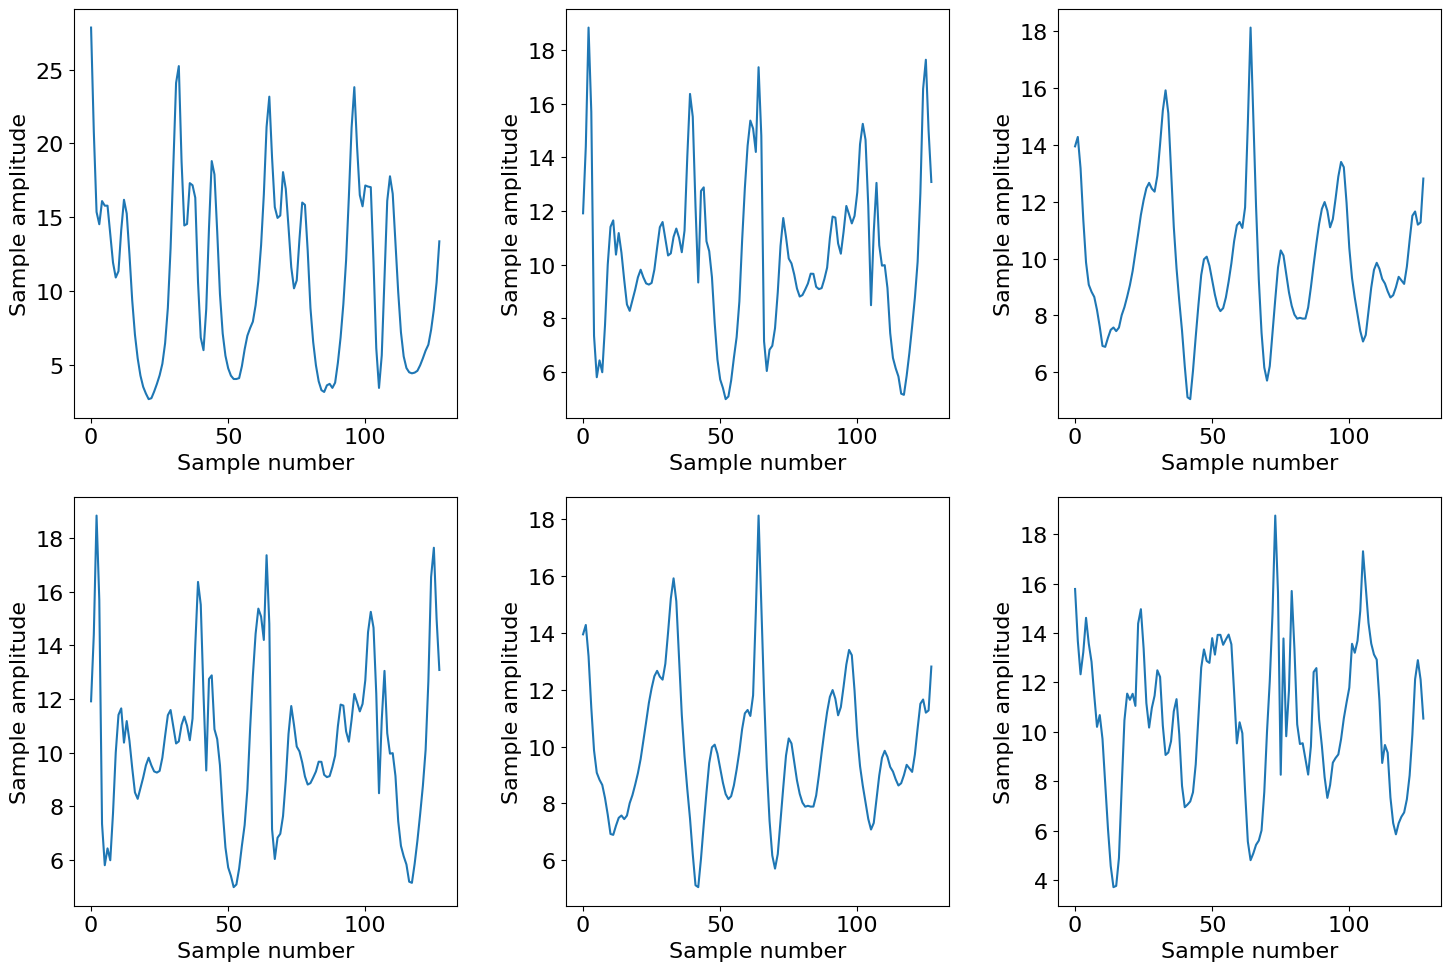

In [ ]:
# Print accelerometer samples
show_sample(accelerometer_train, 6)

### Gyroscope Analysis

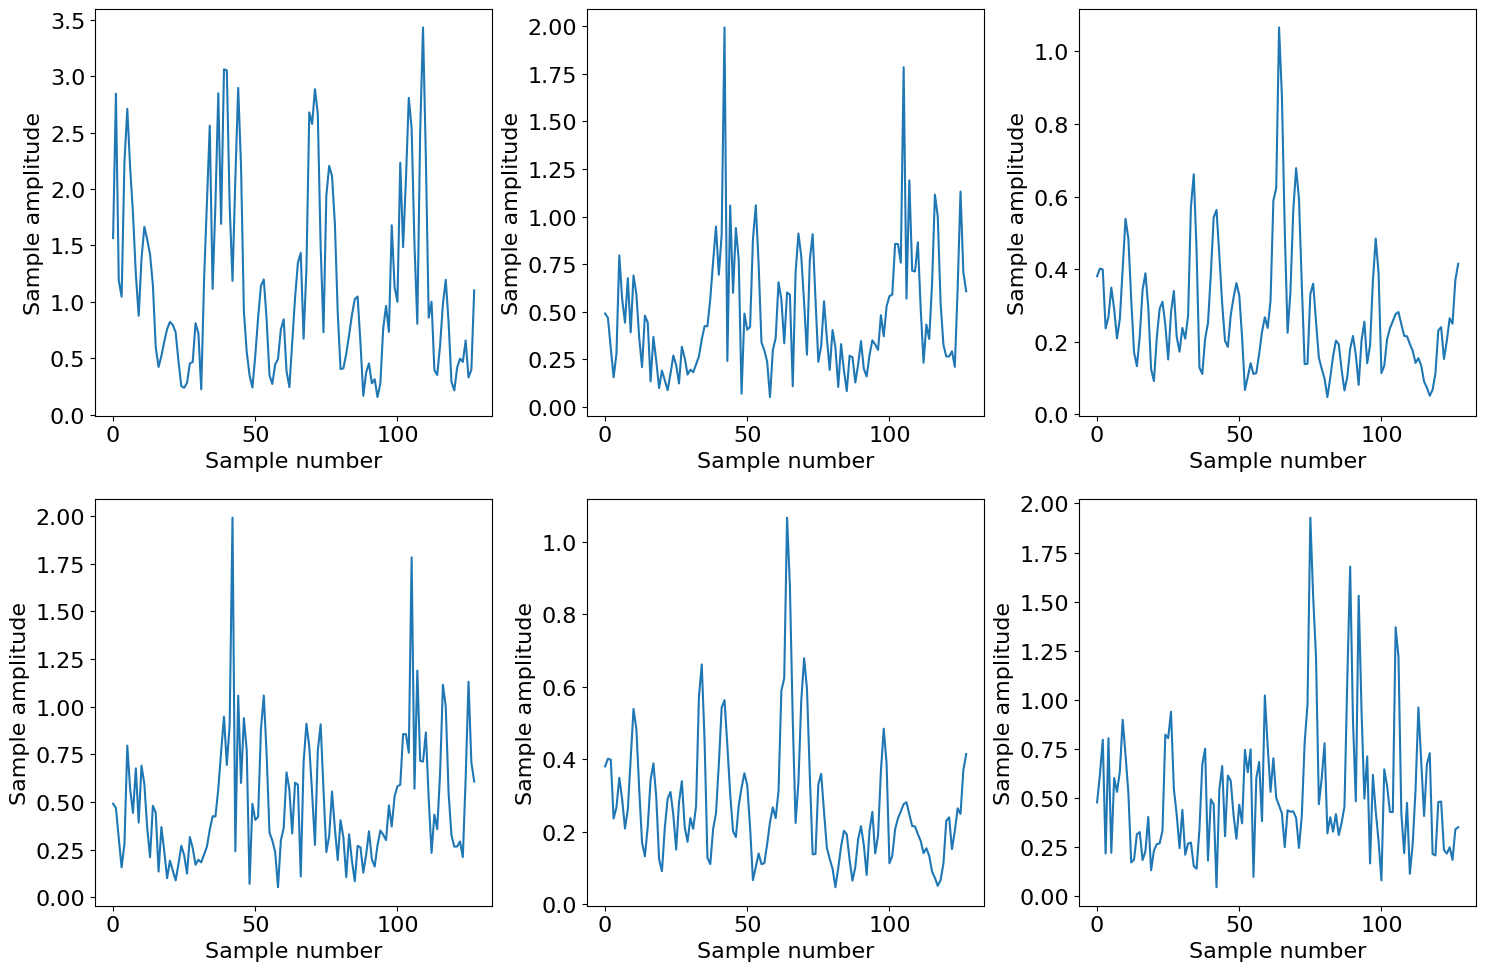

In [60]:
# Print gyroscope samples
show_sample(gyroscope_train, 6)

## Feature Treatment (Steps Extraction)

The steps extraction procedure can be summarized as follows:

* Signal preprocessing: upsampling, to obtain equal sampling frequency for all the considered samples, and filtering to remove high frequency noise.
* Template extraction: the step will be isolated via template matching on the accelerometer magnitude due to its independence from the orientation of the glasses.
* Template matching: given the template use a correlation function and search for the minima to detect the beginning and end of step samples.
* Reference system normalization: since the sensors measurements are relative to their own reference system it is important to transform all the signals into a standard reference system for the whole duration of the step.
* Sample normalization: at this point the extracted data points will not have the same length (since the walking speed can change) so they can't be fed into a convolutional neural network. To solve this the sequences are re-interpolated into fixed length signals.

### No treatment

In [312]:
# Associate the loaded datasets with the final information input

# Train data
final_accelerometer_train = accelerometer_train
final_gyroscope_train = gyroscope_train
final_output_train = output_train

# Test data
final_accelerometer_test = accelerometer_test
final_gyroscope_test = gyroscope_test
final_output_test = output_test

### Treatment Analysis

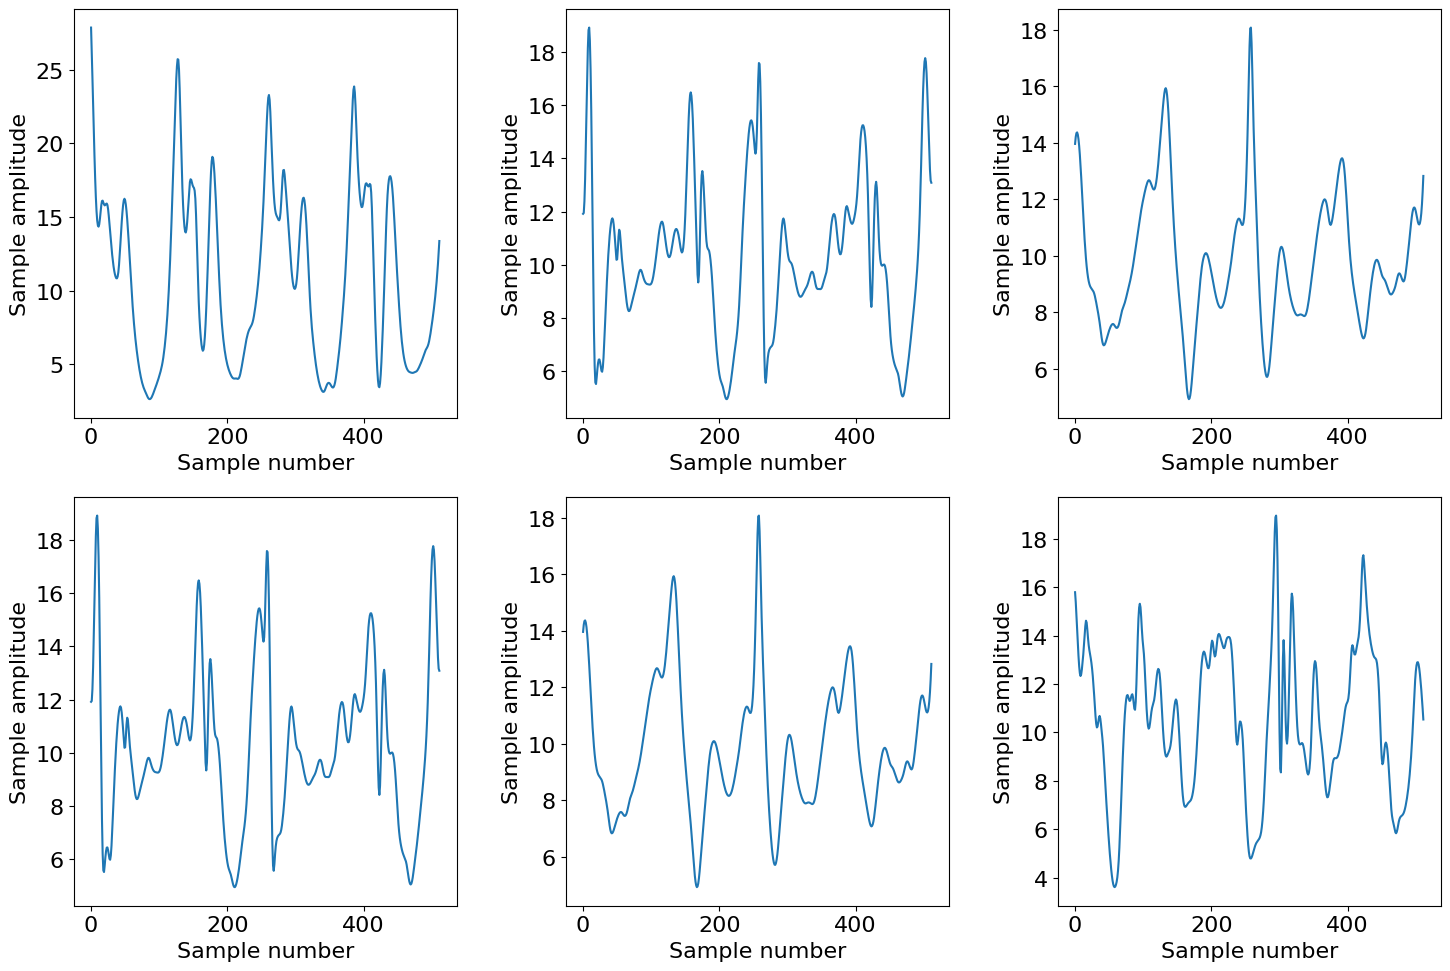

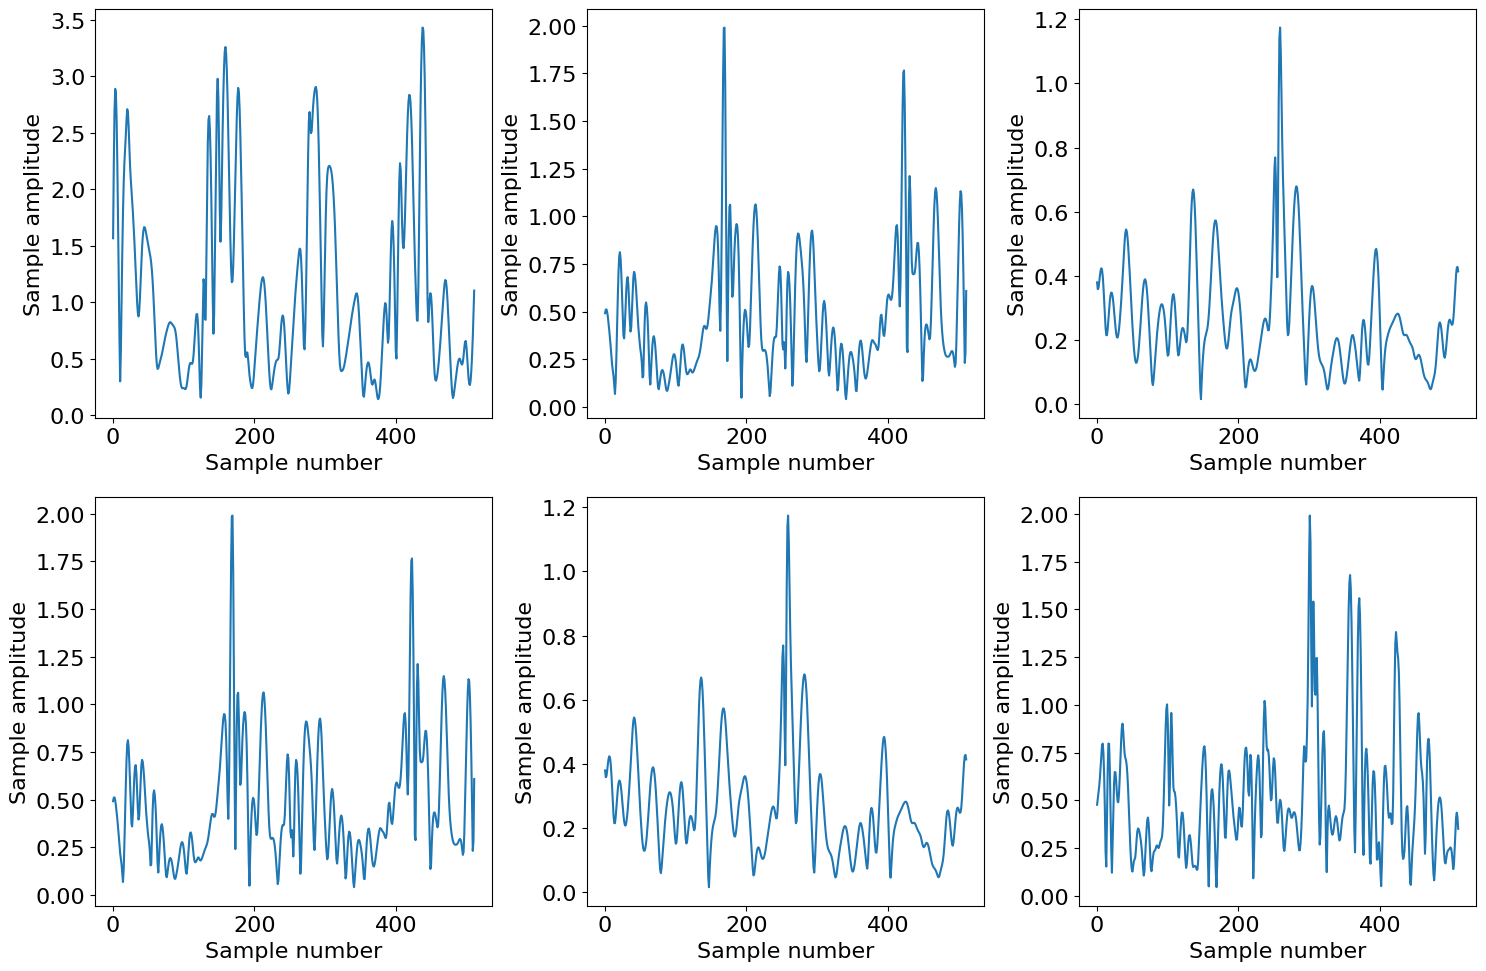

In [164]:
# Print accelerometer samples
show_sample(final_accelerometer_train, 6)

# Print gyroscope samples
show_sample(final_gyroscope_train, 6)

### 1. Signal Preprocessing

#### Upsampling

In [159]:
def sequence_cs_interpolation(data: np.array, fs_original: int = 50, fs_target: int = 200) -> np.array:
    '''
    Upsample a sequence to a higher frequency using cubic spline interpolation.

    Args:
        data (np.array): The input sequence.
        fs_original (int): Original sampling frequency.
        fs_target (int): Target sampling frequency.

    Returns:
        np.array: The upsampled sequence.
    '''

    # Calculate the original time index
    original_timesteps = np.linspace(0, 1, data.shape[1])

    # Calculate the number of target time steps
    n_target = int(data.shape[1] * (fs_target / fs_original))

    # Calculate the target time index
    target_timesteps = np.linspace(0, 1, n_target)

    # Create the array that will hold the interpolated data
    interpolated = []

    # Iterate over the several steps contained in the data
    for step in data:

        # Calculate the cubic spline interpolation
        f = interp1d(original_timesteps, step, axis=0, kind='cubic')

        # Interpolate the signal to the desired time index
        interpolated_step = f(target_timesteps)

        # Append the interpolated step to the destination array
        interpolated.append(interpolated_step)

    # Return the calculated interpolated data
    return np.array(interpolated)

In [160]:
# Upsampling of the accelerometer data
final_accelerometer_train = sequence_cs_interpolation(final_accelerometer_train)
final_accelerometer_test = sequence_cs_interpolation(final_accelerometer_test)

# Upsampling of the gyroscope data
final_gyroscope_train = sequence_cs_interpolation(final_gyroscope_train)
final_gyroscope_test = sequence_cs_interpolation(final_gyroscope_test)

#### Filtering

In [113]:
def fir_filter_signal(signal: np.array, frequency: int = 50, cutoff_hz: int = 20, order: int = 4, ripple_db: int = 60) -> np.array:
    '''
    Applies a low-pass FIR filter to a single signal sample.
    
    Args:
        signal (np.array): The signal sample.
        frequency (int): The sampling frequency of the signal.
        cutoff_hz (int): The cutoff frequency in Hz.
        order (int): The order of the FIR filter.
        ripple_db (int): The ripple in the passband in decibels.
        
    Returns:
        np.array: The filtered signal (Steps x Samples x 3).
    '''

    # Calculate the Nyquist rate
    nyquist_rate = 0.5 * frequency

    # Normalize the cutoff frequency by the Nyquist rate
    normalized_cutoff = cutoff_hz / nyquist_rate

    # Calculate the transition width
    width = 5 / nyquist_rate
    
    # Calculate the filter order and beta using the Kaiser window method
    N, beta = kaiserord(ripple_db, width)
    
    # Make sure the filter order is not too small
    N = max(N, order)
    
    # Design the FIR filter using the Kaiser window
    taps = firwin(N, normalized_cutoff, window=("kaiser", beta))

    # Calculate the symmetric padding
    pad = len(taps) // 2
    
    # Apply the FIR filter
    filtered_data = lfilter(taps, 1.0, signal)
    
    # Return the calculated filtered data with the symmetric padding removed
    return np.array(filtered_data[pad:-pad])

def fir_filter(data: np.array, frequency: int = 50, cutoff_hz: int = 20, order: int = 4, ripple_db: int = 60) -> np.array:
    '''
    Applies a low-pass FIR filter to a signal.
    
    Args:
        data (np.array): The Steps * Samples * 3 input signal.
        frequency (int): The sampling frequency of the signal.
        cutoff_hz (int): The cutoff frequency in Hz.
        order (int): The order of the FIR filter.
        ripple_db (int): The ripple in the passband in decibels.
        
    Returns:
        np.array: The filtered signal (Steps x Samples x 3).
    '''

    # Calculate the Nyquist rate
    nyquist_rate = 0.5 * frequency

    # Normalize the cutoff frequency by the Nyquist rate
    normalized_cutoff = cutoff_hz / nyquist_rate

    # Calculate the transition width
    width = 5 / nyquist_rate
    
    # Calculate the filter order and beta using the Kaiser window method
    N, beta = kaiserord(ripple_db, width)
    
    # Make sure the filter order is not too small
    N = max(N, order)
    
    # Design the FIR filter using the Kaiser window
    taps = firwin(N, normalized_cutoff, window=("kaiser", beta))

    # Calculate the symmetric padding
    pad = len(taps) // 2
    
    # Create an array to store the filtered signal
    filtered_data = np.zeros_like(data)
    
    # Apply the FIR filter to each axis independently
    for step in range(data.shape[0]):
        for feature in range(data.shape[2]):
            filtered_data[step, :, feature] = lfilter(taps, 1.0, data[step, :, feature])

    # Create an array to store the padding free filtered data
    padding_free = []

    # Remove the symmetric padding from each filtered axis
    for step in filtered_data:
        padding_free.append(step[pad:-pad])
    
    # Return the calculated filtered data
    return np.array(padding_free)

In [ ]:
SAMPLING_FREQ = 200

# Filtering of the accelerometer data
final_accelerometer_train = fir_filter(final_accelerometer_train, SAMPLING_FREQ)
final_accelerometer_test = fir_filter(final_accelerometer_test, SAMPLING_FREQ)

# Filtering of the gyroscope data
final_gyroscope_train = fir_filter(final_gyroscope_train, SAMPLING_FREQ)
final_gyroscope_test = fir_filter(final_gyroscope_test, SAMPLING_FREQ)

### 2. Template Extraction

In [170]:
def compute_magnitude(data: np.array) -> np.array:
    '''
    Compute the magnitude of the readings given in an Steps * Samples * 3 matrix.

    Args:
        data (np.array): The matrix containing the readings.

    Returns:
        np.array: A Steps * Samples matrix of magnitudes for each sample.
    '''

    # Return and calculate the magnitude of the given data matrix
    return np.linalg.norm(data, axis=2)

# correlation distance computation
def corr_distance(u: np.array, v: np.array) -> float:
    '''
    Calculate the correlation between to given samples.

    Args:
        u (np.array): The first sample to calculate the correlation with.
        v (np.array): The second sample to calculate the correlation with.

    Returns:
        float: The calculated correlation of the given samples.
    '''

    # Calculate the mean for the first sample
    u_hat = np.mean(u)

    # Calculate the mean for the second sample
    v_hat = np.mean(v)

    # Normalize both samples with their means
    u = u - u_hat
    v = v - v_hat

    # Calculate the correlation between the two samples
    corr = 1 - np.dot(u, v) / np.linalg.norm(u) * np.linalg.norm(v)

    # Return the calculated correlation
    return corr

def parse_indexes(min_indexes: np.array, corrs: np.array, half_window: int = 20) -> np.array:
    '''
    Check if the minimum indexes given are unique minimas in a given window size.

    Args:
        min_indexes (np.array): An array of found minima indexes.
        corrs (np.array): The array of calculated correlation indexes for the sample where the minimas were found.
        half_window (int): Half the size of the minimum search window.

    Returns:
        np.array: The updated minima array.
    '''

    # checking if there is another minimum in a window of size 2*half_window, if so
    # ignore the current minimum

    # Create the array of parsed indexes
    parsed_indexes = []

    # For every minima index check if there is another minima in the given window
    for index in min_indexes:

        # In case there is another minima, ignore the current one
        if min(half_window, index) == np.argmin(corrs[max(index-half_window, 0):min(index+half_window, len(corrs))]):
            parsed_indexes.append(index)

    # Return the calculated unique minima's array
    return np.array(parsed_indexes)

def compute_template(signal: np.array, template_initialization: np.array = None, first_sample_height: int = 12, corr_thr: float = 0.5, frequency: int = 50, template_size: int = 64, window_size: int = 25, order: int = 4, ripple_db: int = 60, cutoff_hz: int = 3):

    # Calculate the first index where there is a peak
    first_index = np.where(signal > first_sample_height)[0][0]

    # Cut everything before the first peak (transitory information)
    processed_signal = signal[first_index:].copy()

    # Normalize the signal to improve detection
    processed_signal -= processed_signal.mean()

    # Filter with low cutoff frequency to find where to begin the template
    filtered_signal = fir_filter_signal(processed_signal, frequency, cutoff_hz, order, ripple_db)

    # Find the second minima of the signal (more stable)
    minima_ind = argrelmin(filtered_signal)[0][1]

    # Search for the actual minima in a one second time window in the original signal
    actual_minima = np.argmin(processed_signal[minima_ind:minima_ind + template_size]) + minima_ind

    # Calculate half of the template size
    half_size = template_size // 2

    # If there is no preinitialized template, select a one second window around the minima
    if template_initialization is None:
        template = processed_signal[actual_minima - half_size:actual_minima + half_size]
    else:
        template = template_initialization.copy()

    # Define the starting window center
    i = half_size

    # Compute the correlation function to detect steps
    while i < len(processed_signal) - window_size - half_size:

        # Create an array to store correlation values
        corrs = []

        # Check all the sub-windows inside the main window
        for j in range(i, i + window_size):

            # Get a sub-window of samples
            sample = processed_signal[j - half_size:j + half_size]

            # Delta function to check if the sample is worth considering
            delta = lambda x: np.max(x) - np.min(x)

            # Check if this is actual walking data or just noise
            if delta(sample) < delta(template) / 10:

                # Set correlation to ignore this sample
                corr = 1

            else:

                # Compute the correlation between the sample and the current template
                corr = corr_distance(template, sample)

            # Add the computed correlation to the list
            corrs.append(corr)

        # Convert array into np.array
        corrs = np.array(corrs)

        # Search for samples whose correlation is smaller than the threshold
        search_indexes = np.where(corrs < corr_thr)[0]

        # Store the correlation values of those samples
        searched_values = corrs[search_indexes]

        # Look for the first minina in the correlation vector
        minima = argrelmin(searched_values)[0]

        # Store the indexes of the minima
        min_indexes = search_indexes[minima]
        
        # Discard minima that are not the absolute minima within a small window (stability)
        min_indexes = parse_indexes(min_indexes, corrs)

        # If no minima found or not enough, break the loop
        if len(min_indexes) < 2:
            break
        
        # Move the window forward based on the detected minima
        i += min_indexes[1]
        
        # Update the template by a weighted average of the old template and the new signal
        template = 0.9 * template + 0.1 * processed_signal[i - half_size:i + half_size]
    
    # Return the obtained template
    return template

In [171]:
SAMPLING_FREQ = 200
TEMPLATE_SIZE = 256
WINDOW_SIZE = 100

# Calculate the magnitude of the accelerometer samples
magnitude = compute_magnitude(final_accelerometer_train)

# Calculate the step template for template matching of samples
step_template = compute_template(signal = magnitude[0], frequency = SAMPLING_FREQ, template_size = TEMPLATE_SIZE, window_size = WINDOW_SIZE)

### 3. Template Matching

#### Continuous Signal

In [212]:
def correct_missing_indexes(min_indexes):
    # getting the median step length
    median = np.median(np.diff(min_indexes))
    start_index = min_indexes[0]
    indexes = [start_index]
    for min_index in min_indexes[1:]:
        # checking if the step interval is greater than 1.5 times the median, if so
        # the interval is divided in round(len(interval) / median intervals)
        if  (min_index - start_index) > 1.5 * median:
            n_missed = int(np.round((min_index - start_index) / median))
            for j in range(1, n_missed):
                indexes.append(
                    int(start_index + j * np.round((min_index - start_index) / n_missed))
                )
        indexes.append(min_index)
        start_index = min_index
    return np.array(indexes)

def count_steps(signal: np.array, template: np.array, thr: float = 0.45) -> np.array:
    '''
    Calculate the step indexes on a sample, given a step template.

    Args:
        signal (np.array): The sample to extract the steps from.
        template (np.array): The template for a step.
        thr (float): The threshold for the correlation between the sample and the template.

    Returns:
        np.array: The array of step indexes from the sample.
    '''

    # Calculate the template size
    template_size = len(template)

    # Normalize the signal with the signal mean
    signal -= signal.mean()

    # Create the array to store the correlation of the obtained samples
    corrs = []

    # Iterates over all the possible samples within a signal
    for i in range(len(signal) - template_size):
        
        # Get the sample wanted to test for matching
        sample = signal[i:i+template_size]

        # Delta function to calculate worthness of verification
        delta = lambda x: np.max(x) - np.min(x)

        # Check if the sample is worth checking
        if delta(sample) < delta(template) / 2:

            # Set correlation to ignore this sample
            corr = 1

        else:

            # Calculate the correlation of the sample with the template
            corr = corr_distance(template, sample)

        # Append the calculate correlation
        corrs.append(corr)

    # Convert correlation array into np.array
    corrs = np.array(corrs)

    # Same as above, finding the indexes of the minima and removing bad ones
    search_indexes = np.where(corrs < thr)
    searched_values = corrs[search_indexes]
    minima = argrelmin(searched_values)[0]
    search_indexes = search_indexes[0]
    min_indexes = search_indexes[minima]
    min_indexes = parse_indexes(min_indexes, corrs)

    # this function should be used only if you are sure that a person kept walking,
    # in this way you can make sure that even if a step is not detected a good
    # estimate of the step is still obtained
    new_indexes = correct_missing_indexes(min_indexes)

    # Return the list of calculated step indexes
    return new_indexes

def count_steps_all(magnitude_data: np.array, template: np.array, thr: float = 0.45) -> np.array:
    '''
    Calculate the step indexes on all the samples collected by the accelerometer, given a step template.

    Args:
        magnitude_data (np.array): The array of the magnitude of all samples collected by the accelerometer.
        template (np.array): The template used for step matching.
        thr (float): The correlation threshold for template matching.

    Returns:
        np.array: An array of the cycles of all the samples collected.
    '''

    # Build and return the array of cycle indexes of all samples
    return [count_steps(signal, template, thr) for signal in magnitude_data]

def get_cycles(cycles: np.array, data: np.array) -> np.array:
    '''
    Transform the samples to have only steps in them.

    Args:
        cycles (np.array): The array of step cycles.
        data (np.array): The array of data sampled from a device.

    Returns:
        np.array: The array of the resampled data.
    '''

    # Create an array which is gonna store the new data
    new_data = []

    # Iterate over all the samples contained in the data
    for sample_i in range(len(data)):

        # Create the array which is gonna store the new signal
        pieces = []

        # Define the sample for this iteration
        signal = data[sample_i]
        cycle = cycles[sample_i]

        # Iterate over all the steps
        for step_i in range(len(cycle) - 1):

            # Add the step exctracted from the sample to the final sample
            pieces += signal[cycle[step_i]:cycle[step_i + 1]]

        # Append the steps collected to the new data
        new_data.append(np.array(pieces))

    # Convert and return the new data into np.array
    return np.array(new_data)

In [253]:
# Calculate the step cycles of every sample
cycles = count_steps_all(magnitude, step_template)

# Resample the accelerometer data for including only steps
final_accelerometer_train = get_cycles(cycles, final_accelerometer_train)
final_accelerometer_test = get_cycles(cycles, final_accelerometer_test)

# Resample the gyroscope data for including only steps
final_gyroscope_train = get_cycles(cycles, final_gyroscope_train)
final_gyroscope_test = get_cycles(cycles, final_gyroscope_test)

[ 83 213]
[ 68 193]
[ 34  68 115 162 207]
[ 47 127 247]
[ 34 174]
[ 86 209]
[ 82 209]
[ 88 213]
[ 89 160 211]
[ 92 217]
[ 17  44 147 246]
[ 87 212]
[ 48 191]
[ 98 148 199 222]
[ 90 215]
[ 88 214]
[ 37  94 219]
[ 56 180]
[ 83 168 237]
[ 61 185]
[]
[ 88 213]
[ 81 196]
[ 95 211]
[ 87 213]
[ 84 210]
[ 83 205]
[ 88 213]
[ 86 211]
[ 30  92 154 188]
[ 59 186]
[ 74 198]
[ 83 210]
[]
[149 250]
[ 83 210]
[ 33  89 160 211]
[]
[ 19 145 200]
[ 67 207]
[]
[ 85 211]
[ 66 191]
[ 89 214]
[ 67 193 246]
[ 29  91 214]
[ 32 164]
[ 74 200]
[ 84 208]
[]
[ 67 194]
[ 89 215]
[ 85 209]
[ 39 175]
[ 60 181]
[ 63 190]
[ 90 214]
[ 89 216]
[ 92 217]
[ 88 212]
[ 89 216]
[  7  73 194]
[ 75 200]
[ 95 221]
[ 84 210]
[ 81 207]
[ 87 212]
[ 61 188 239]
[ 89 219]
[ 73 196]
[ 69 191]
[ 71 194]
[ 64 191]
[ 66 197]
[ 80 207]
[ 90 215]
[ 78 203]
[ 93 222]
[ 62 186]
[ 67 157 195]
[ 93 216]
[ 89 212]
[  3  91 218]
[ 77 209]
[ 68 131 158 206 254]
[ 27 124 249]
[]
[ 67 199]
[ 85 213]
[  6 105 229]
[ 81 190]
[ 68 190]
[ 11  36  84 1

/home/guinucool/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guinucool/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[ 67 188]
[]
[ 81 206]
[ 84 208]
[ 90 212]
[ 77 204]
[ 68 194]
[ 93 218]
[ 86 211]
[ 93 217]
[ 90 214]
[ 85 214]
[39]
[ 85 211]
[ 65 185]
[ 93 217]
[ 79 163 204]
[ 47 199]
[ 87 213]
[ 87 212]
[ 65 188]
[ 80 203]
[ 63 189]
[ 86 212]
[]
[]
[ 94 217]
[]
[]
[ 88 212]
[ 81 204]
[45]
[ 39 161]
[]
[ 91 211]
[ 89 213]
[ 87 212]
[ 89 214]
[ 89 216]
[ 61 198]
[ 89 213]
[ 87 213]
[]
[ 64 208]
[ 58 185]
[ 88 212]
[ 91 214]
[ 83 209]
[ 86 212]
[ 63 190]
[ 88 213]
[ 93 217]
[ 75 204]
[ 65 193]
[ 87 214]
[ 14  77 203]
[ 62 182]
[ 89 214]
[ 89 213]
[  2  62 182]
[ 89 213]
[ 64 194]
[ 92 213]
[  7 108 208]
[ 94 153 217]
[ 91 216]
[]
[ 90 214]
[  2  89 214]
[ 91 214]
[ 27  67 111 155 200]
[  1  88 213]
[]
[ 48 148 250]
[ 71 196]
[ 68 181]
[ 71 197 248]
[ 58 185]
[ 90 216]
[ 90 216]
[ 89 215]
[ 57 171]
[ 38  88 211]
[ 74 199 251]
[]
[ 86 211]
[ 89 213]
[ 85 209]
[ 60 187 240]
[ 89 213]
[]
[ 88 214]
[ 68 198]
[ 80 206]
[ 85 212]
[ 97 215]
[ 85 210]
[ 89 213]
[ 96 218]
[]
[ 86 212]
[ 91 216]
[ 36 112 188 2

KeyboardInterrupt: 

#### Step Interpolated Signal

In [268]:
def step_extraction_signal(signal: np.array, step_length: int = 64) -> np.array:
    '''
    Exctract the steps from a interpolated step annotated sample.

    Args:
        signal (np.array): The signal which is wanted for the step exctraction.
        step_length (int): The step length in the sample.

    Returns:
        np.array: A Signals * Steps * Samples * 3 matrix of the separated steps from the sample.
    '''

    # Create the pieces array where the steps will be stored
    pieces = []

    # Create the start index for the step exctraction
    i = 0

    # While there are steps to extract, exctract them
    while (i + step_length) <= len(signal):

        # Extract a step sample
        pieces.append(signal[i:i + step_length].reshape((i + step_length - i, -1)))

        # Increase the start index for the next step
        i += step_length

    # Return the exctracted steps
    return np.array(pieces)

def step_extraction_data(data: np.array, step_length: int = 64) -> np.array:
    '''
    Exctract the steps from all the samples collected by a device.

    Args:
        data (np.array): The data which contains the samples wanted for exctraction.
        step_length (int): The step length in the sample.

    Returns:
        np.array: An array of the data resampled into separated steps.
    '''

    # Create and return the new data
    return np.array([step_extraction_signal(signal, step_length) for signal in data])

In [313]:
# Exctract the steps from the accelerometer data
steps_accelerometer_train = step_extraction_data(final_accelerometer_train)
steps_accelerometer_test = step_extraction_data(final_accelerometer_test)

# Exctract the steps from the gyroscope data
steps_gyroscope_train = step_extraction_data(final_gyroscope_train)
steps_gyroscope_test = step_extraction_data(final_gyroscope_test)

### 4. Reference System Normalization

In [ ]:
def normalize_principal_vector(v, v0):
    # if the versors look more or less in the same direction then keep v as it is
    # otherwise swap it
    if v.reshape(1, 3)@v0.reshape((3, 1)) < 0:
        return -v
    else:
        return v

def get_accelerations_directions(acceleration_cycles, gyro_cycles):
    # normalizing accelerometer and gyroscope data w.r.t. a common reference system
    new_accelerations = []
    new_gyroscopes = []
    for i, (cycle, gyro_cycle) in enumerate(zip(acceleration_cycles, gyro_cycles)):




        ########################## PUT YOUR CODE HERE ##########################
        # getting the average acceleration mean in the cycle i.e. the first axis
        first_axis = cycle.mean(axis=0)
        ########################## PUT YOUR CODE HERE ##########################




        # normalizing the vector that will represent the gravity versor
        gravity = first_axis.reshape(1, 3) / np.linalg.norm(first_axis)
        normalized_acc = []
        normalized_gyr = []

        # getting the component along the gravity versor
        normalized_acc.append(cycle@gravity.T)
        normalized_gyr.append(gyro_cycle@gravity.T)

        # removing the component along the gravity axis
        main_direction_acc = normalized_acc[0] * gravity
        main_direction_gyr = normalized_gyr[0] * gravity
        planar_direction_acc = cycle - main_direction_acc
        planar_direction_gyr = gyro_cycle - main_direction_gyr




        ########################## PUT YOUR CODE HERE ##########################
        # computing PCA along the resulting plane to obtain the remaining directions
        pca_acc = PCA(2).fit(planar_direction_acc)
        pca_gyr = PCA(2).fit(planar_direction_gyr)

        #getting the components
        acc_y, acc_z = pca_acc.components_
        gyr_y, gyr_z = pca_gyr.components_
        ########################## PUT YOUR CODE HERE ##########################





        # this is needed to make sure that the principal vectors look all in a
        # similar direction, for this reason they are oriented towards the first
        # chosen versors
        if i == 0:
            acc_y0, acc_z0 = acc_y, acc_z
            gyr_y0, gyr_z0 = gyr_y, gyr_z
        acc_y = normalize_principal_vector(acc_y, acc_y0)
        acc_z = normalize_principal_vector(acc_z, acc_z0)
        gyr_y = normalize_principal_vector(gyr_y, gyr_y0)
        gyr_z = normalize_principal_vector(gyr_z, gyr_z0)

        # adding the remaining components
        normalized_acc.append(cycle@acc_y.reshape(3, 1))
        normalized_acc.append(cycle@acc_z.reshape(3, 1))
        normalized_gyr.append(gyro_cycle@gyr_y.reshape(3, 1))
        normalized_gyr.append(gyro_cycle@gyr_z.reshape(3, 1))
        new_accelerations.append(np.concatenate(normalized_acc, axis=1))
        new_gyroscopes.append(np.concatenate(normalized_gyr, axis=1))

    return new_accelerations, new_gyroscopes

def get_accelerations_directions_all(acceleraromter_steps_data: np.array, gyroscope_steps_data: np.array) -> list:
    '''
    Normalize the reference system of all the samples (step exctracted) collected by the accelerometer and gyroscope.

    Args:
        acceleraromter_steps_data (np.array): The data samples collected by the accelerometer.
        gyroscope_steps_data (np.array): The data samples collected by the gyroscope.

    Returns:
        list: A list with both all the normalized samples of the accelerometer and gyroscopes.
    '''

    # Create and return the list of normalized samples
    return [get_accelerations_directions(acc_steps, gyro_steps) for acc_steps, gyro_steps in zip(acceleraromter_steps_data, gyroscope_steps_data)]

In [314]:
# Normalize the reference system for training data
normalized_samples_train = get_accelerations_directions_all(steps_accelerometer_train, steps_gyroscope_train)

# Normalize the reference system for test data
normalized_samples_test = get_accelerations_directions_all(steps_accelerometer_test, steps_gyroscope_test)

### 5. Sample Normalization

#### Process Definition

In [319]:
def normalize_length(steps: np.array, target_sample_length: int = 200) -> np.array:
    '''
    Interpolate a step sample into the desired sample length.

    Args:
        steps (np.array): The array of step samples of a subject collected sample.
        target_sample_length (int): The desired lenght for the step sample.

    Returns:
        np.array: The interpolated step in the desired format.
    '''

    final = []

    for step in steps:

        # Consider only the first step
        step = np.array(step)

        # Create the vector of values for a certain axis
        step_vect = []

        # Iterate over all the axis of the step
        for vec in step.T:

            # Get the indexes for all the axis samples
            x = np.arange(len(vec))

            # Create a cubic spline with the characteritcs of the axis signal
            cs = CubicSpline(x, vec)

            # Create the new linear space with the target length
            new_x = np.linspace(0, len(vec), target_sample_length)

            # Calculate the interpolated signal in the desired axis
            interpolated = cs(new_x)

            # Append the interpolated data to the vector
            step_vect.append(interpolated)

        for xd in np.vstack(step_vect).T:
            final.append(xd)

    # Convert and return the sample in the desired form
    return np.array(final)

def merge_different_runs(normalized_samples: list) -> tuple[np.array, np.array]:
    '''
    Convert the reference system normalized step exctracted samples into the desired format to feed the neural network.

    Args:
        normalized_samples (list): The list of accelerometer and gyroscope reference system normalized samples.

    Returns:
        tuple[np.array, np.array]: The accelerometer and gyroscope normalized samples ready to be fed to the neural network.
    '''
    
    # Create the final accelerometer normalized value array
    accelerometer = []

    # Create the final gyroscope normalized value array
    gyroscope = []
    
    # Iterate over all the accelerometer and gyroscope samples
    for acc, gyro  in normalized_samples:

        # Normalize and append one of the accelerometer
        accelerometer += list([normalize_length(acc)])

        # Normalize and append one of the gyroscope
        gyroscope += list([normalize_length(gyro)])

    # Return the normalized and correctly structured samples    
    return np.array(accelerometer), np.array(gyroscope)

#### Application to the data

In [320]:
# Normalize the training samples
final_accelerometer_train, final_gyroscope_train = merge_different_runs(normalized_samples_train)

# Normalize the testing samples
final_accelerometer_test, final_gyroscope_test = merge_different_runs(normalized_samples_test)

In [328]:
X_train.shape

(33104, 400, 6)

## Neural Network Models

In [294]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input, LSTM, Concatenate
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

### Preprocessing of the Data (General Procedure)

#### Concatenation of the Accelerometer and Gyroscope Data

In [325]:
# Combine the data into one single matrix (Steps * 128 * 6)
combined_data_train = np.concatenate([final_accelerometer_train, final_gyroscope_train], axis=-1)
combined_data_test = np.concatenate([final_accelerometer_test, final_gyroscope_test], axis=-1)

#### Normalization of the Input Data

In [326]:
# Create the normalization scaler
scaler = StandardScaler()

# Fit and normalize the training data to the scaler
X_train = scaler.fit_transform(combined_data_train.reshape(-1, 6)).reshape(combined_data_train.shape)

# Normalize the test data
X_test = scaler.transform(combined_data_test.reshape(-1, 6)).reshape(combined_data_test.shape)

#### One-Hot Enconding of the Output Labels

In [327]:
# Convert training labels to One-Hot
Y_train = to_categorical(final_output_train)

# Convert test labels to One-Hot
Y_test = to_categorical(final_output_test)

#### Utilities

In [298]:
def create_output_layers(num_classes: int, density: int = 128, activation: str = 'relu', dropout: float = 0.3) -> list:
    '''
    Create the standard output layers of a classification neural network with the given parameters.

    Args:
        num_classes (int): The number of classes that model can predict.
        dropout (float): The dropout rate of the output layer.
        activation (str): The activation function applied after the dense output layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        list: The list of layers created with the given parameters.
    '''

    # Create the layers array
    layers = []

    # Add the dense layer
    layers.append(Dense(density, activation=activation))

    # Add the dropout layer
    layers.append(Dropout(dropout))

    # Add the output layer
    layers.append(Dense(num_classes, activation='softmax'))

    # Return the created layer list
    return layers

### CNN (Convolutional Neural Network)

#### Creation of CNN Models

In [300]:
FILTER_SIZE = 64

def create_cnn_layers(input_shape: tuple[int, int], num_layers: int = 3, dropout: float = 0.3, pool_size: int = 2, kernel_size: int = 3, activation: str = 'relu') -> list:
    '''
    Create the layers of a convolutional neural network with the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_layers (int): The number of layers the model will have.
        dropout (float): The dropout rate after every layer.
        pool_size (int): Takes the maximum value from every pool_size time steps.
        kernel_size (int): The size of each filter.
        activation (str): The activation function applied after every layer.

    Returns:
        list: The list of layers created with the given parameters.
    '''

    # Create the layers array
    layers = []

    # Create the filter size variable that will increase every layer
    filter_size = FILTER_SIZE

    # Add the input layer
    layers.append(Input(shape=input_shape))

    # Iterate over the process of every layer creation
    for layer in range(num_layers):

        # Add the 1D Concolutional layer
        layers.append(Conv1D(filters=filter_size, kernel_size=kernel_size, activation=activation))

        # Add the normalization layer
        layers.append(BatchNormalization())

        # Add the pooling layer
        layers.append(MaxPooling1D(pool_size=pool_size))

        # Check if this is the last layer
        if layer == num_layers - 1:

            # Add the dropout layer
            layers.append(Dropout(dropout + 0.1))

        # In case it is not the last layer
        else:

            # Add the dropout layer
            layers.append(Dropout(dropout))

        # Double the filter size
        filter_size *= 2

    # Add the flattening layer
    layers.append(Flatten())

    # Return the created layer list
    return layers

def create_cnn(input_shape: tuple[int, int], num_classes: int, num_layers: int = 3, dropout: float = 0.3, pool_size: int = 2, kernel_size: int = 3, activation: str = 'relu', density: int = 128) -> Sequential:
    '''
    Create a convolutional neural network with the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_classes (int): The number of classes that model can predict.
        num_layers (int): The number of layers the model will have.
        dropout (float): The dropout rate after every layer.
        pool_size (int): Takes the maximum value from every pool_size time steps.
        kernel_size (int): The size of each filter.
        activation (str): The activation function applied after every layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        Sequential: A sequential CNN model created with the given parameters.
    '''

    # Create the layers array
    layers = create_cnn_layers(input_shape, num_layers, dropout, pool_size, kernel_size, activation)

    # Add the output layers
    layers += create_output_layers(num_classes, density, activation, dropout + 0.2)

    # Create and return the CNN model
    return Sequential(layers)

#### Building the CNN Model

##### No Hyperparameter Tuning (Default Model Parameters)

In [329]:
# Create the default CNN model
model = create_cnn(X_train.shape[1::], Y_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### LSTM (Long Short-Term Memory)

#### Creation of LSTM Models

In [9]:
NEURON_SIZE = 64

def create_lstm_layers(input_shape: tuple[int,int], num_layers: int = 2, input_dropout: float = 0.0, recurrent_dropout: float = 0.0) -> list:
    '''
    Create the layers of a Long Short-Term Memory neural network based on the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_layers (int): The number of layers the model will have.
        input_dropout (float): The input dropout rate of every layer.
        recurrent_dropout (float): The hidden state dropout rate of every layer.

    Returns:
        list: The list of layers created with the given parameters.
    '''

    # Create the layers array
    layers = []

    # Create the neuron size variable that will decrease every layer
    neuron_size = int(NEURON_SIZE * (2 ** (num_layers - 1)))

    # Add the input layer
    layers.append(Input(shape=input_shape))

    # Iterate over the process of every layer creation
    for layer in range(num_layers):

        # Evaluate if this is the last layer
        return_seq = (layer != num_layers - 1)

        # Add the LSTM layer
        layers.append(LSTM(units=neuron_size, return_sequences=return_seq, dropout=input_dropout, recurrent_dropout=recurrent_dropout))

        # Add the normalization layer
        layers.append(BatchNormalization())

        # Half the neuron size
        neuron_size //= 2

    # Return the created layer list
    return layers

def create_lstm(input_shape: tuple[int,int], num_classes: int, num_layers: int = 2, input_dropout: float = 0.0, recurrent_dropout: float = 0.0, output_dropout: float = 0.3, activation: str = 'relu', density: int = 128) -> Sequential:
    '''
    Create a Long Short-Term Memory neural network based on the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_classes (int): The number of classes that model can predict.
        num_layers (int): The number of layers the model will have.
        input_dropout (float): The input dropout rate of every layer.
        recurrent_dropout (float): The hidden state dropout rate of every layer.
        output_dropout (float): The output dropout rate of the output layer.
        activation (str): The activation function applied after the dense output layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        Sequential: A sequential LSTM model created with the given parameters.
    '''

    # Create the layers array
    layers = create_lstm_layers(input_shape, num_layers, input_dropout, recurrent_dropout)

    # Add the output layers
    layers += create_output_layers(num_classes, density, activation, output_dropout)

    # Create and return the LSTM model
    return Sequential(layers)

#### Building the LSTM Model

##### No Hyperparameter Tuning (Default Model Parameters)

In [128]:
# Create the default LSTM model
model = create_lstm(X_train.shape[1::], Y_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### CNN + LSTM

#### Creation of CNN + LSTM

In [43]:
def create_parallel_network(first_network_layers: list, second_network_layers: list, num_classes: int, droupout: float = 0.3, activation: str = 'relu', density: int = 128) -> Model:
    '''
    Create a parallel neural network with the two given neural paths and the output parameters.

    Args:
        first_network_layers (list): The first neural path.
        second_network_layers (list): The second neural path.
        num_classes (int): The number of classes that model can predict.
        dropout (float): The output dropout rate of the output layer.
        activation (str): The activation function applied after the dense output layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        Model: A parallel model created with the given parameters.
    '''

    # Extract the input layer from both pathways
    first_input = first_network_layers[0]
    second_input = second_network_layers[0]

    # Extract the layers from the list of the first pathway
    first_output = first_input
    for layer in first_network_layers[1::]:
        first_output = layer(first_output)

    # Extract the layers from the list of the second pathway
    second_output = second_input
    for layer in second_network_layers[1::]:
        second_output = layer(second_output)

    # Concatenate the two neural pathways
    concatenated = Concatenate(axis=1)([first_output, second_output])

    # Extract the output layers
    output_layers = concatenated
    for layer in create_output_layers(num_classes, density, activation, droupout):
        output_layers = layer(output_layers)

    # Create and return the parallel model
    return Model(inputs=[first_input, second_input], outputs=output_layers)

#### Building the CNN + LSTM Model

##### No Hyperparameter Tuning (Default Model Parameters)

In [44]:
# Create the default CNN + LSTM model
model = create_parallel_network(create_cnn_layers(X_train.shape[1::]), create_lstm_layers(X_train.shape[1::]), Y_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Adapt of the CNN + LSTM Input Data

In [45]:
# Adapt input feature train data
X_train = [X_train, X_train]

# Adapt input feature test data
X_test = [X_test, X_test]

### Evaluation of the Neural Network Model

In [302]:
MODELS = 'models/'
MODEL_EXTENSION = '.keras'

!mkdir models

mkdir: cannot create directory ‘models’: File exists


#### Training the Neural Network Model

##### Epochs = 50 | Batch-Size = 32 | Validation-Split = 20% (Default Training Parameters)

In [330]:
# Train the model with the given data
model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2
)

Epoch 1/50
828/828 - 39s - 47ms/step - accuracy: 0.4535 - loss: 2.4706 - val_accuracy: 0.8111 - val_loss: 0.9149
Epoch 2/50
828/828 - 37s - 45ms/step - accuracy: 0.6749 - loss: 1.3670 - val_accuracy: 0.8564 - val_loss: 0.6896
Epoch 3/50
828/828 - 37s - 45ms/step - accuracy: 0.7409 - loss: 1.0703 - val_accuracy: 0.8831 - val_loss: 0.5850
Epoch 4/50
828/828 - 37s - 45ms/step - accuracy: 0.7717 - loss: 0.9262 - val_accuracy: 0.9017 - val_loss: 0.4957
Epoch 5/50
828/828 - 39s - 47ms/step - accuracy: 0.8009 - loss: 0.7836 - val_accuracy: 0.9071 - val_loss: 0.4541
Epoch 6/50
828/828 - 40s - 48ms/step - accuracy: 0.8192 - loss: 0.7213 - val_accuracy: 0.9180 - val_loss: 0.3943
Epoch 7/50
828/828 - 40s - 48ms/step - accuracy: 0.8296 - loss: 0.6663 - val_accuracy: 0.9252 - val_loss: 0.3914
Epoch 8/50
828/828 - 40s - 48ms/step - accuracy: 0.8439 - loss: 0.5954 - val_accuracy: 0.9261 - val_loss: 0.4178
Epoch 9/50
828/828 - 40s - 48ms/step - accuracy: 0.8567 - loss: 0.5472 - val_accuracy: 0.9385 - 

#### Saving and Loading of Trained Neural Network Models

##### Saving of the Trained Neural Network Model

In [304]:
# Get the desired name from user to save the model
name = input('Save model with name:')

# Save the model with the desired name
model.save(MODELS + name  + MODEL_EXTENSION)

##### Loading of a Pre-Trained Neural Network Model

In [310]:
# Get the desired name from user to save the model
name = input('Load model with name:')

# Save the model with the desired name
model = load_model(MODELS + name  + MODEL_EXTENSION)

/home/guinucool/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Evaluation of the Neural Network Model

In [331]:
# Calculate the accuracy and loss of the model in the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

# Print the model performance
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Loss: {test_loss:.4f}')

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9181 - loss: 0.8922
Accuracy: 0.9168
Loss: 0.8920
